# Basic Examples of einmesh

This notebook demonstrates the core functionality of einmesh through simple examples. We'll explore:

1. Creating basic 2D meshgrids using linear spaces
2. Working with 3D grids using different space types (LogSpace and UniformDistribution)
3. Using repeated dimensions in patterns

einmesh provides an intuitive, einops-style syntax for creating multi-dimensional meshgrids, making it easy to define complex coordinate systems with just a few lines of code.


In [1]:
import matplotlib.pyplot as plt

# Einmeshes are created from spaces and distribution which are backend agnostic.
from einmesh import (
    LinSpace,
    LogSpace,
    UniformDistribution,
)

# To use a specific backend, just import the einmesh function from the desired backend.
from einmesh.numpy import einmesh
# from einmesh.jax import einmesh
# from einmesh.torch import einmesh

The first thing to know is the use of einstein notation to create the shapes of the meshgrid that is being generated by einmesh. An einmesh pattern consists of space separated names ("x y z"), parenthesis("(x y) z"), stars ("* x y z") and ellipsis ("* x ..."). 

- Names express which dimension should correspond to a keyword Space argument 
- Parenthesis flattens axis into each other, just like einops.rearrange
- A star tells einmesh to stack the outputs into the dimension of the star, instead of returning a tuple
- Ellipsis allows for sampling of spaces that are not named in the keyword arguments, but instead are passed as regular arguments

In the below example we showcase this by creating a 2D square mesh between 0 and 1, with 10 points in each dimension.

(10, 10) (10, 10)


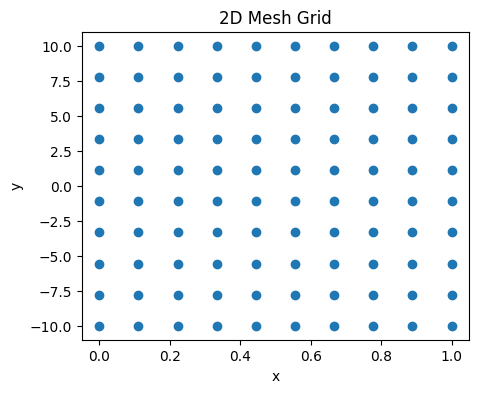

In [2]:
x_coords, y_coords = einmesh("x y", x=LinSpace(start=0, end=1, num=10), y=LinSpace(start=-10, end=10, num=10))
print(x_coords.shape, y_coords.shape)

plt.figure(figsize=(5, 4))
plt.scatter(x_coords, y_coords)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Mesh Grid")
plt.show()

By changing the space type, we change the type of sampling

(10, 10) (10, 10)


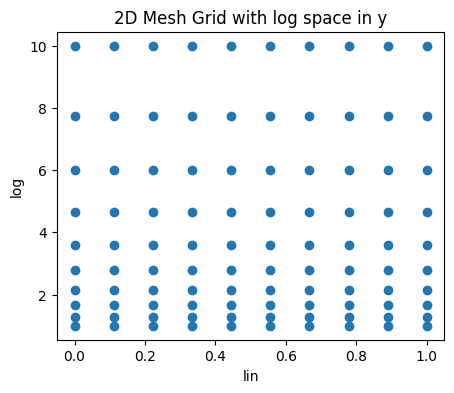

In [3]:
lin_coords, log_coords = einmesh(
    "lin log", lin=LinSpace(start=0, end=1, num=10), log=LogSpace(start=0, end=1, num=10, base=10)
)
print(lin_coords.shape, log_coords.shape)
plt.figure(figsize=(5, 4))
plt.scatter(lin_coords, log_coords)
plt.xlabel("lin")
plt.ylabel("log")
plt.title("2D Mesh Grid with log space in y")
plt.show()

If one wants to have two dimension that are identically sampled, one can repeat an axis in the pattern. 

In [4]:
x_coords_repeated, y_coords_repeated = einmesh("x x", x=LinSpace(start=0, end=1, num=10))
print(x_coords_repeated.shape, y_coords_repeated.shape)

(10, 10) (10, 10)


If you want the meshgrid to return a stacked tensor, you can use the * operator. The meshgrid will be stacked in the dimensions in which the * is located in the pattern.

In [5]:
coords_stacked_start = einmesh("* x x", x=LinSpace(start=0, end=1, num=10))
print(f"{coords_stacked_start.shape=}")
coords_stacked_mid = einmesh("x * x", x=LinSpace(start=0, end=1, num=10))
print(f"{coords_stacked_mid.shape=}")
coords_stacked_end = einmesh("x x *", x=LinSpace(start=0, end=1, num=10))
print(f"{coords_stacked_end.shape=}")

coords_stacked_start.shape=(2, 10, 10)
coords_stacked_mid.shape=(10, 2, 10)
coords_stacked_end.shape=(10, 10, 2)


In style with einops.rearrange, axis can be combined (flattened), by using a parenthesis.

In [6]:
coords_flattened = einmesh("* (x y)", x=LinSpace(0, 1, num=10), y=LinSpace(0, 1, num=10))
print(f"{coords_flattened.shape=}")
everything_flattened = einmesh("(* x y)", x=LinSpace(0, 1, num=10), y=LinSpace(0, 1, num=10))
print(f"{everything_flattened.shape=}")

coords_flattened.shape=(2, 100)
everything_flattened.shape=(200,)


The grids that are generated by einmesh be of arbitrary dimensionality, and arbitrary combination of spaces. So if you want to generate a 9D grid, it is as easy as changing the pattern.

In [7]:
nine_d_grid = einmesh(
    "* x y z w v u t s r",
    x=LinSpace(start=0, end=1, num=1),
    y=LinSpace(start=0, end=1, num=2),
    z=LogSpace(start=0, end=1, num=3),
    w=LinSpace(start=0, end=1, num=4),
    v=LogSpace(start=0, end=1, num=5),
    u=LinSpace(start=0, end=1, num=6),
    t=LinSpace(start=0, end=1, num=7),
    s=UniformDistribution(low=0, high=1, num=8),
    r=LinSpace(start=0, end=1, num=9),
)
print(f"{nine_d_grid.shape=}")

nine_d_grid.shape=(9, 1, 2, 3, 4, 5, 6, 7, 8, 9)


And you can combine axis as you want

In [8]:
nine_d_grid = einmesh(
    "x (y z w) v (u t) (* s) r",
    x=LinSpace(start=0, end=1, num=1),
    y=LinSpace(start=0, end=1, num=2),
    z=LogSpace(start=0, end=1, num=3),
    w=LinSpace(start=0, end=1, num=4),
    v=LogSpace(start=0, end=1, num=5),
    u=LinSpace(start=0, end=1, num=6),
    t=LinSpace(start=0, end=1, num=7),
    s=UniformDistribution(low=0, high=1, num=8),
    r=LinSpace(start=0, end=1, num=9),
)
print("Shape should be (x, y*z*w, v, u*t, stacked_dim*s, r)")
print(f"i.e Shape should be {1, 2 * 3 * 4, 5, 6 * 7, 9 * 8, 9}")
print(f"{nine_d_grid.shape=}")

Shape should be (x, y*z*w, v, u*t, stacked_dim*s, r)
i.e Shape should be (1, 24, 5, 42, 72, 9)
nine_d_grid.shape=(1, 24, 5, 42, 72, 9)


If you want to create a tensor without having to specify the keywords in the pattern, you can unpack a list of spaces and use the ellipsis function to include them in the pattern.

In [9]:
spaces = [LinSpace(1, 1, 5)] * 8  # Some programmatic way to create a list of spaces

# Unpack the list and specify where the ellipsis (unpacking) should be
nine_d_grid = einmesh("* ...", *spaces)
print(nine_d_grid.shape)

(8, 5, 5, 5, 5, 5, 5, 5, 5)


And all of these methods can be combined to your hearts content.

In [10]:
from einmesh.spaces import NormalDistribution

tensor = einmesh(
    "(x *) (... y) z y w w",
    *([LinSpace(1, 1, 5)] * 3),
    x=LinSpace(0, 2, 3),
    y=NormalDistribution(0, 1, 5),
    z=LinSpace(0, 1, 6),
    w=LogSpace(0, 1, 7),
)
print(tensor.shape)

(27, 625, 6, 5, 7, 7)


As we noted above, the einmesh pattern can be reused across different backends. Making it easy to switch between them without any changes other than an import. 

In [11]:
from einmesh.jax import einmesh as einmesh_jax
from einmesh.numpy import einmesh as einmesh_np
from einmesh.torch import einmesh as einmesh_torch

# np example
np_tensor = einmesh_np(
    "(x *) (... y) z y w w",
    *([LinSpace(1, 1, 5)] * 3),
    x=LinSpace(0, 2, 3),
    y=NormalDistribution(0, 1, 5),
    z=LinSpace(0, 1, 6),
    w=LogSpace(0, 1, 7),
)
print(type(np_tensor))
print(np_tensor.shape)

# jax example
jax_tensor = einmesh_jax(
    "(x *) (... y) z y w w",
    *([LinSpace(1, 1, 5)] * 3),
    x=LinSpace(0, 2, 3),
    y=NormalDistribution(0, 1, 5),
    z=LinSpace(0, 1, 6),
    w=LogSpace(0, 1, 7),
)
print(type(jax_tensor))
print(jax_tensor.shape)

# torch example
torch_tensor = einmesh_torch(
    "(x *) (... y) z y w w",
    *([LinSpace(1, 1, 5)] * 3),
    x=LinSpace(0, 2, 3),
    y=NormalDistribution(0, 1, 5),
    z=LinSpace(0, 1, 6),
    w=LogSpace(0, 1, 7),
)
print(type(torch_tensor))
print(torch_tensor.shape)

<class 'numpy.ndarray'>
(27, 625, 6, 5, 7, 7)


TypeError: einmesh() takes 1 positional argument but 4 were given